# [__FIFA 2021 Limpieza y Análisis exploratorio de datos__](https://www.kaggle.com/datasets/yagunnersya/fifa-21-messy-raw-dataset-for-cleaning-exploring/data)

<div style="text-align: center;">
    <img src="image.png" width="900"/>
</div>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")  # Ignora todos los warnings

df = pd.read_csv('fifa21_raw_data.csv')
df.head(3)

,photoUrl,LongName,playerUrl,Nationality,Positions,Name,Age,↓OVA,POT,Team & Contract,...,A/W,D/W,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits
0,https://cdn.sofifa.com/players/158/023/21_60.png,Lionel Messi,http://sofifa.com/player/158023/lionel-messi/2...,Argentina,RW ST CF,L. Messi,33,93,93,\n\n\n\nFC Barcelona\n2004 ~ 2021\n\n,...,Medium,Low,5 ★,85,92,91,95,38,65,\n372
1,https://cdn.sofifa.com/players/020/801/21_60.png,C. Ronaldo dos Santos Aveiro,http://sofifa.com/player/20801/c-ronaldo-dos-s...,Portugal,ST LW,Cristiano Ronaldo,35,92,92,\n\n\n\nJuventus\n2018 ~ 2022\n\n,...,High,Low,5 ★,89,93,81,89,35,77,\n344
2,https://cdn.sofifa.com/players/200/389/21_60.png,Jan Oblak,http://sofifa.com/player/200389/jan-oblak/210005/,Slovenia,GK,J. Oblak,27,91,93,\n\n\n\nAtlético Madrid\n2014 ~ 2023\n\n,...,Medium,Medium,3 ★,87,92,78,90,52,90,\n86


# PREPROCESAMIENTO
- Manejo de datos faltantes  
- Reestructuración de columnas  
- Conversión de columnas a formatos numéricos  
- Descomposición de fechas
- Limpieza de caracteres no deseados y saltos de línea 
- Separación de campos combinados
- Manejo de valores atípicos(Outliers)

In [2]:
# Verificar filas duplicadas
print(df.duplicated().sum())

df.drop_duplicates(inplace=True)

1


### Datos faltantes

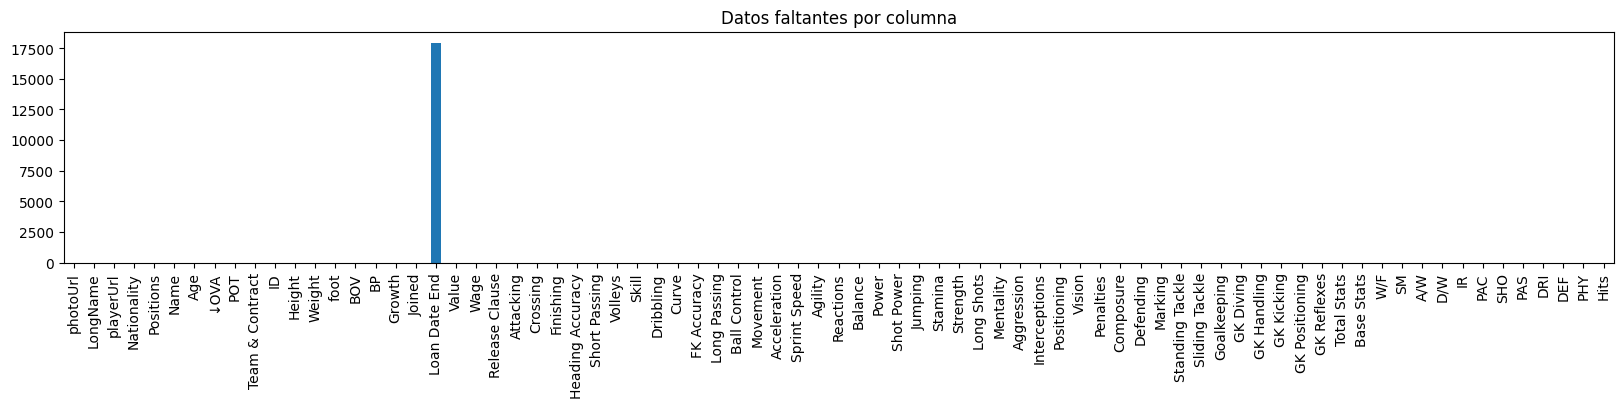

In [3]:
df.isna().sum().plot(kind='bar', figsize=(20, 3))
plt.title("Datos faltantes por columna");

Debido a que más del 90% de los datos en __Loan Date End__ son valores faltantes, se eliminara esta columna.

In [4]:
round(df["Loan Date End"].isna().sum() / df.shape[0] * 100, 2)

94.66

In [5]:
df.drop('Loan Date End', axis=1, inplace=True)

LongName esta mas completa que Name, asi que se eliminara junto a otras columnas innecesarias

In [6]:
df[['LongName', 'Name']].head(3)

,LongName,Name
0,Lionel Messi,L. Messi
1,C. Ronaldo dos Santos Aveiro,Cristiano Ronaldo
2,Jan Oblak,J. Oblak


In [7]:
df.drop(['Name', 'ID', 'playerUrl', 'photoUrl'], axis=1, inplace=True)

### Renombrar y Reordenar columnas

In [8]:
df = df.rename(columns={
    'LongName': 'Long_name',
    '↓OVA': 'OVA',
    'Height': 'Height_(ft/in)',
    'Weight': 'Weight_(lb)',
    'Team & Contract': 'Team_&_Contract',
    'Heading Accuracy': 'Heading_accuracy',
    'Short Passing': 'Short_passing',
    'FK Accuracy': 'fk_accuracy',
    'Long Passing': 'Long_passing',
    'Ball Control': 'Ball_control',
    'Sprint Speed': 'Sprint_speed',
    'Shot Power': 'Shot_power',
    'Long Shots': 'Long_shots',
    'Standing Tackle': 'Standing_tackle',
    'Sliding Tackle': 'Sliding_tackle',
    'GK Diving': 'gk_diving',
    'GK Handling': 'gk_handling',
    'GK Kicking': 'gk_kicking',
    'GK Positioning': 'gk_positioning',
    'GK Reflexes': 'gk_reflexes',
    'Total Stats': 'Total_stats',
    'Base Stats': 'Base_stats'
})

In [9]:
# Definir el nuevo orden de las columnas
columns_order = ['Long_name', 'Age', 'Nationality', 'Team_&_Contract', 'Positions', 'Height_(ft/in)', 'Weight_(lb)', 'foot', 'Joined', 'Value', 'Wage', 'Release Clause', 'OVA']

remaining_columns = [col for col in df.columns if col not in columns_order]

# Reordenar las columnas
df = df[columns_order + remaining_columns]
df.head(3)

,Long_name,Age,Nationality,Team_&_Contract,Positions,Height_(ft/in),Weight_(lb),foot,Joined,Value,...,A/W,D/W,IR,PAC,SHO,PAS,DRI,DEF,PHY,Hits
0,Lionel Messi,33,Argentina,\n\n\n\nFC Barcelona\n2004 ~ 2021\n\n,RW ST CF,"5'7""",159lbs,Left,"Jul 1, 2004",€67.5M,...,Medium,Low,5 ★,85,92,91,95,38,65,\n372
1,C. Ronaldo dos Santos Aveiro,35,Portugal,\n\n\n\nJuventus\n2018 ~ 2022\n\n,ST LW,"6'2""",183lbs,Right,"Jul 10, 2018",€46M,...,High,Low,5 ★,89,93,81,89,35,77,\n344
2,Jan Oblak,27,Slovenia,\n\n\n\nAtlético Madrid\n2014 ~ 2023\n\n,GK,"6'2""",192lbs,Right,"Jul 16, 2014",€75M,...,Medium,Medium,3 ★,87,92,78,90,52,90,\n86


### Transformar __Height__ y __Weight__ a formato totalmente numérico

In [10]:
display('Antes', df[['Height_(ft/in)', 'Weight_(lb)']].head(3))

df['Height_(ft/in)'] = df['Height_(ft/in)'].str.replace("'", '.').str.replace('"', '').astype(float)  # Se eliminan los caracteres no numericos y se convierte a formato decimal
df['Weight_(lb)'] = df['Weight_(lb)'].str.replace('lbs', '').astype(int)    # Se elimina la palabra 'lbs' y se convierte a formato entero

display('Despues', df[['Height_(ft/in)', 'Weight_(lb)']].head(3))

'Antes'

,Height_(ft/in),Weight_(lb)
0,"5'7""",159lbs
1,"6'2""",183lbs
2,"6'2""",192lbs


'Despues'

,Height_(ft/in),Weight_(lb)
0,5.7,159
1,6.2,183
2,6.2,192


### Separar __Joined__ en Día, Mes y Año

In [11]:
df[['Joined']].head(3)

,Joined
0,"Jul 1, 2004"
1,"Jul 10, 2018"
2,"Jul 16, 2014"


In [12]:
df['Joined'] = pd.to_datetime(df['Joined'])

df['Day'] = df['Joined'].dt.day
df['Month'] = df['Joined'].dt.month
df['Year'] = df['Joined'].dt.year

df.drop('Joined', axis=1, inplace=True)

df.head(3)

,Long_name,Age,Nationality,Team_&_Contract,Positions,Height_(ft/in),Weight_(lb),foot,Value,Wage,...,PAC,SHO,PAS,DRI,DEF,PHY,Hits,Day,Month,Year
0,Lionel Messi,33,Argentina,\n\n\n\nFC Barcelona\n2004 ~ 2021\n\n,RW ST CF,5.7,159,Left,€67.5M,€560K,...,85,92,91,95,38,65,\n372,1,7,2004
1,C. Ronaldo dos Santos Aveiro,35,Portugal,\n\n\n\nJuventus\n2018 ~ 2022\n\n,ST LW,6.2,183,Right,€46M,€220K,...,89,93,81,89,35,77,\n344,10,7,2018
2,Jan Oblak,27,Slovenia,\n\n\n\nAtlético Madrid\n2014 ~ 2023\n\n,GK,6.2,192,Right,€75M,€125K,...,87,92,78,90,52,90,\n86,16,7,2014


### Convertir __Value__, __Wage__ y __Release Clause__ a columnas de tipo Entero

In [13]:
df[["Value", "Wage", "Release Clause"]].head(3)

,Value,Wage,Release Clause
0,€67.5M,€560K,€138.4M
1,€46M,€220K,€75.9M
2,€75M,€125K,€159.4M


In [14]:
for col in ["Value", "Wage", "Release Clause"]:
    df[col] = df[col].str.replace("€", "")  

    # Se multiplica por mil solo los valores que contienen 'M' para dejar la columna en formato de miles (K)
    df.loc[df[col].str.contains("M"), col] = df.loc[df[col].str.contains("M"), col].str.replace("M", "").astype(float) * 1000   
    
    if col == 'Wage':
        df.loc[df[col].str.contains("K"), col] = df.loc[df[col].str.contains("K"), col].str.replace("K", "").astype(float) * 1000

    df[col] = df[col].apply(lambda x: x.replace("K", "") if isinstance(x, str) else x)  # Se elimina la 'K solo en valores tipo String
    df[col] = df[col].astype(int)

df = df.rename(columns={"Value": "Value_(K)", "Wage": "Wage", "Release Clause": "Release_Clause_(K)"})

df[["Value_(K)", "Wage", "Release_Clause_(K)"]].sample(3)

,Value_(K),Wage,Release_Clause_(K)
13316,625,1000,1300
7476,1600,3000,3500
14559,425,500,999


### Remover saltos de línea en __Hits__

In [15]:
df[["Hits"]].sample(3)

,Hits
6466,\n2
356,\n40
10435,\n1


In [16]:
df.Hits.unique()[350:]

array(['\n358', '\n555', '\n335', '\n856', '\n1.8K', '\n230', '\n250',
       '\n792', '\n400', '\n126', '\n342', '\n270', '\n529', '\n445',
       '\n830', '\n380', '\n881', '\n240', '\n160', '\n378', '\n598',
       '\n433', '\n202', 1, 2, 3, 16, 5, 208, 4, 11, 6, 19, 27, 8, 7, 13,
       10, 12, 9, 17, 21, 15, 20, 50, 18, 38, 43, 61, 49, 25, 22, 86, 14,
       26, 30, 60, 58], dtype=object)

In [17]:
# 'Hits' contiene tanto strings como valores numéricos, así que con 'isinstance' se aplica 'strip' solo a los strings y se evitan errores.
df["Hits"] = df["Hits"].apply(lambda x: x.strip() if isinstance(x, str) else x)

# 'na=False' evita errores al buscar 'K' en valores No-string o Faltantes
df.loc[df["Hits"].str.contains("K", na=False), "Hits"] = df.loc[df["Hits"].str.contains("K", na=False), "Hits"].str.replace("K", "").astype(float) * 1000
df["Hits"] = df["Hits"].astype(int)

df[["Hits"]].sample(3)

,Hits
536,59
17033,1
16662,2


### Separar __Team & Contract__
La columna __Team & Contract__ se compone de 3 formatos: <br>
1. [Equipo, AñoInicio, ~, AñoFin]
2. [Equipo, Mes, Dia, AñoFin, 'On', 'Loan']
3. [Equipo + 'Free']

Segun el formato, se devuelve unicamente la Fecha de finalizacion y si no se encuentra, se retorna Nan

In [18]:
def extract_year(x):
    if x[-1].isdigit():		# [Equipo, AñoInicio, ~, AñoFin]
        return x[-1]
    elif len(x) >= 3 and x[-3].isdigit():	# [Equipo, Mes, Dia, AñoFin, 'On', 'Loan']
        return x[-3]
    
    return np.nan			# [Equipo + 'Free']

In [19]:
df['Team'] = df['Team_&_Contract'].str.strip().str.split('\n').str[0]
df['Contract_end'] = df['Team_&_Contract'].str.replace('\n', '').str.split().apply(lambda x: extract_year(x))

df.dropna(inplace=True)
df['Contract_end'] = df['Contract_end'].astype(int)
df.drop('Team_&_Contract', axis=1, inplace=True)

df.head(3)

,Long_name,Age,Nationality,Positions,Height_(ft/in),Weight_(lb),foot,Value_(K),Wage,Release_Clause_(K),...,PAS,DRI,DEF,PHY,Hits,Day,Month,Year,Team,Contract_end
0,Lionel Messi,33,Argentina,RW ST CF,5.7,159,Left,67500,560000,138400,...,91,95,38,65,372,1,7,2004,FC Barcelona,2021
1,C. Ronaldo dos Santos Aveiro,35,Portugal,ST LW,6.2,183,Right,46000,220000,75900,...,81,89,35,77,344,10,7,2018,Juventus,2022
2,Jan Oblak,27,Slovenia,GK,6.2,192,Right,75000,125000,159400,...,78,90,52,90,86,16,7,2014,Atlético Madrid,2023


### Eliminar el caracter '★' de las columnas que los contienen

In [20]:
star_cols = ["W/F", "SM", "IR"]
df[star_cols].iloc[:3]

,W/F,SM,IR
0,4 ★,4★,5 ★
1,4 ★,5★,5 ★
2,3 ★,1★,3 ★


In [21]:
for col in star_cols:
    df[col] = df[col].str.replace('★', '').astype(int)

df[star_cols].iloc[:3]

,W/F,SM,IR
0,4,4,5
1,4,5,5
2,3,1,3


### Valores Atípicos

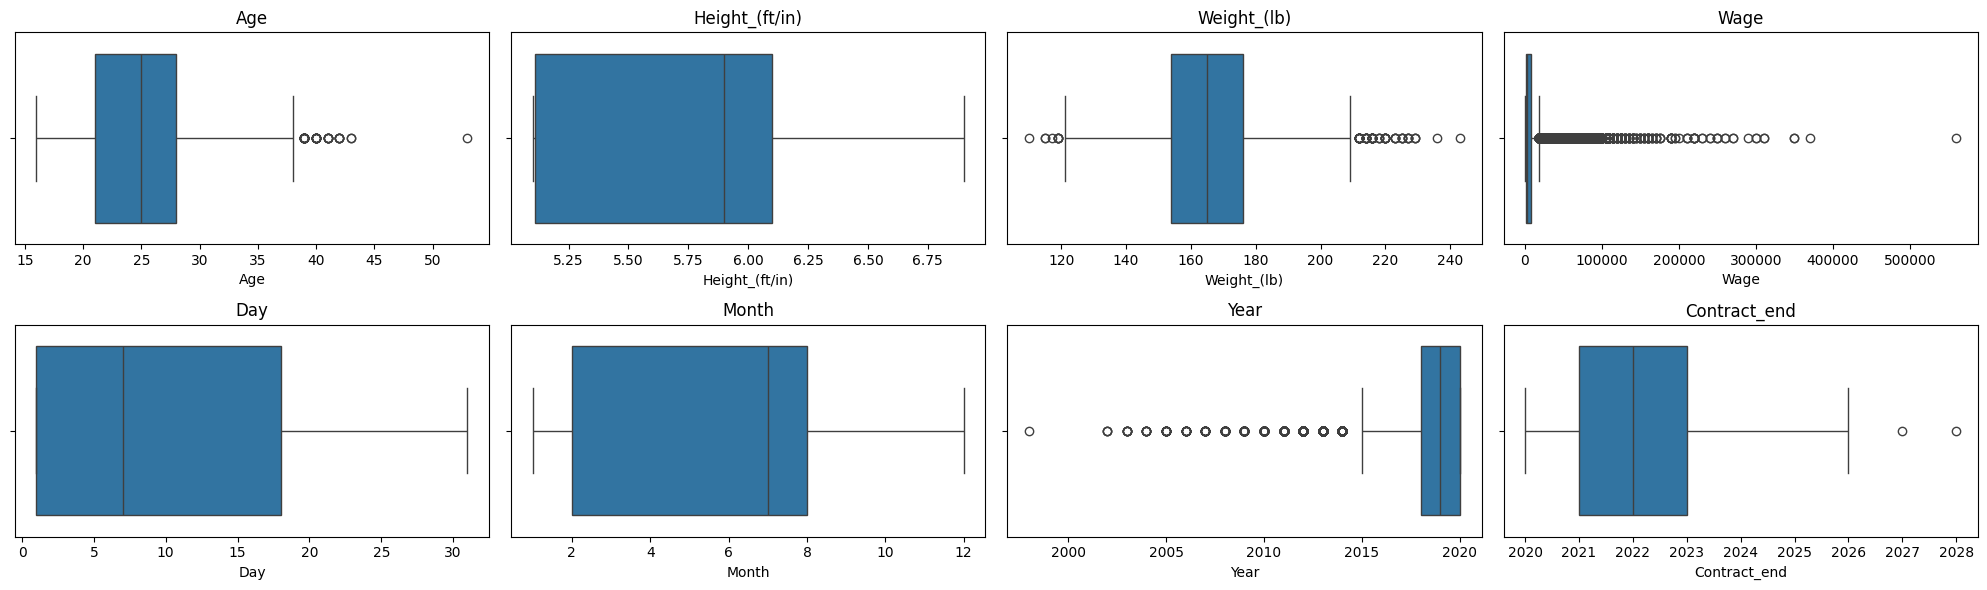

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 6))
ax = ax.flatten()

for i, col in enumerate(['Age', 'Height_(ft/in)', 'Weight_(lb)', 'Wage', 'Day', 'Month', 'Year', 'Contract_end']):
    sns.boxplot(x=df[col], ax=ax[i])
    ax[i].set_title(col)

plt.tight_layout();

> Aunque se observan posibles outliers en variables como __Edad__, __Peso__, __Salario__ y __Año de finalización del contrato__, estos valores se consideran normales dentro del contexto del fútbol profesional. Por ejemplo, existen jugadores veteranos en activo, futbolistas con contexturas físicas particulares, contratos que se extienden más allá de lo habitual y salarios extremadamente altos que corresponden a estrellas reconocidas. <br><br> 
Por lo tanto, no hay una razón justificada para eliminarlos del análisis.

# EDA

## Futbolistas con mayor antigüedad en un equipo

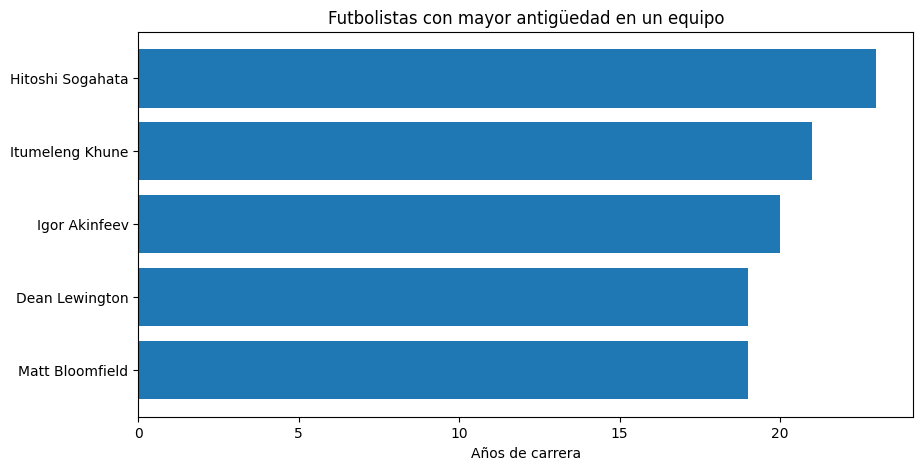

In [23]:
# Se ordenan los valores de Mayor a Menor y se invierten para que al graficar, los datos se muestren de forma ascendente
antiguedad = (df['Contract_end'] - df['Year']).sort_values(ascending=False).head()[::-1]
veteranos = df['Long_name'].loc[antiguedad.index]   # Extraer los nombres correspondientes a las antiguedades

plt.figure(figsize=(10,5))
plt.barh(veteranos, antiguedad)

plt.xlabel('Años de carrera')
plt.title('Futbolistas con mayor antigüedad en un equipo');

## Top 10 paises con más futbolistas

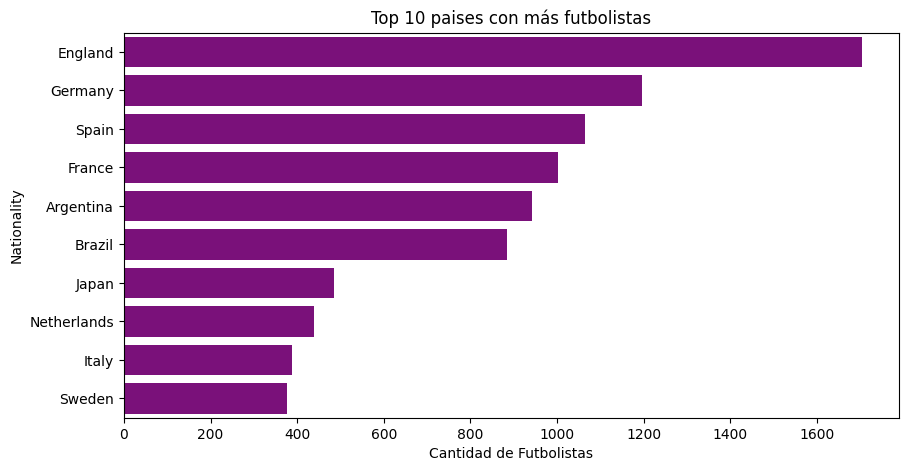

In [24]:
top_10_countries = df.Nationality.value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_10_countries.values, y=top_10_countries.keys(), data=top_10_countries.to_frame(), color='darkmagenta')

plt.xlabel("Cantidad de Futbolistas")
plt.title("Top 10 paises con más futbolistas");

## Top 10 Futbolistas más valiosos del 2021


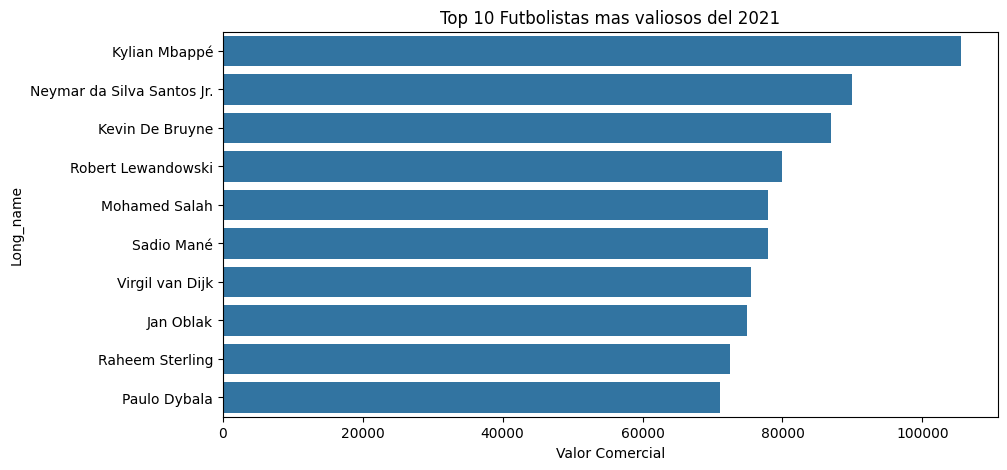

In [25]:
players = df[["Long_name", "Value_(K)"]]

# Se ordenan los valores de Mayor a Menor
players = players.sort_values(by="Value_(K)", ascending=False)

# Extraer los jugadores Top 10
top_10_players = players.head(10)


plt.figure(figsize=(10, 5))
sns.barplot(x=top_10_players["Value_(K)"], y=top_10_players["Long_name"], data=df)

plt.xlabel("Valor Comercial")
plt.title("Top 10 Futbolistas mas valiosos del 2021");

## Rango de edad más común entre los futbolistas

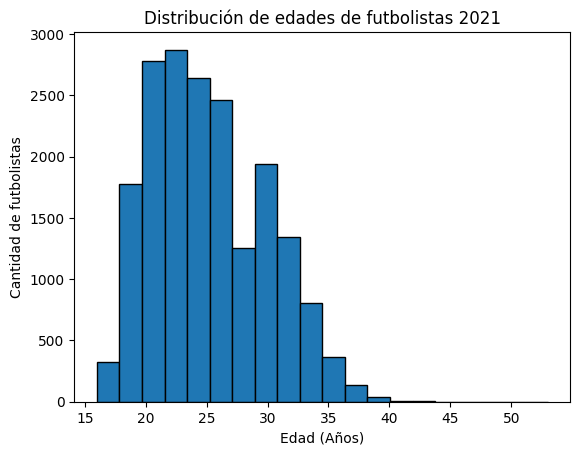

In [26]:
df.Age.plot(kind='hist', bins=20, edgecolor="k")

plt.xlabel("Edad (Años)")
plt.ylabel("Cantidad de futbolistas")
plt.title("Distribución de edades de futbolistas 2021");

> Las edades predominantes estan entre los 20 y 25 años.

## Valoración general vs Potencia

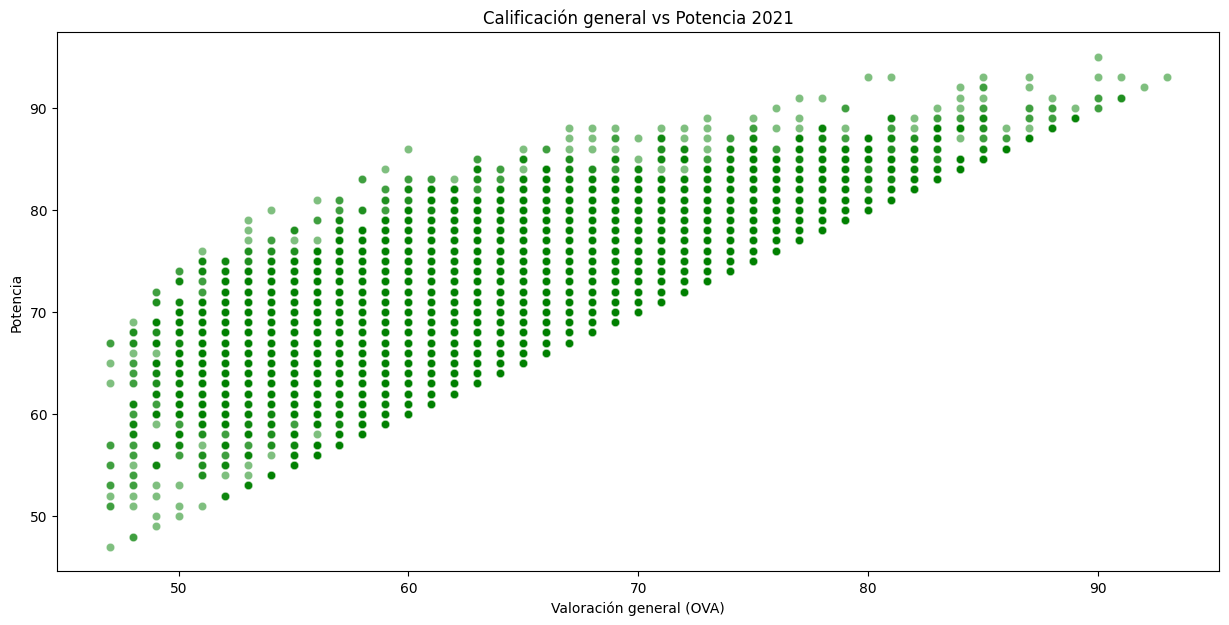

In [27]:
plt.figure(figsize=(15, 7))
sns.scatterplot(x="OVA", y="POT", data= df, color="g", alpha=0.5)

plt.xlabel("Valoración general (OVA)")
plt.ylabel("Potencia")
plt.title("Calificación general vs Potencia 2021");

> El diagrama de dispersión evidencia una correlación positiva significativa entre la Valoración general (OVA) y la Potencia (POT) de los jugadores en el año 2021. Esta asociación puede ser utilizada como un indicador predictivo del desarrollo proyectado de los futbolistas, así como una variable relevante en modelos de estimación de valor de mercado.

# Salario vs Valor comercial del futbolista

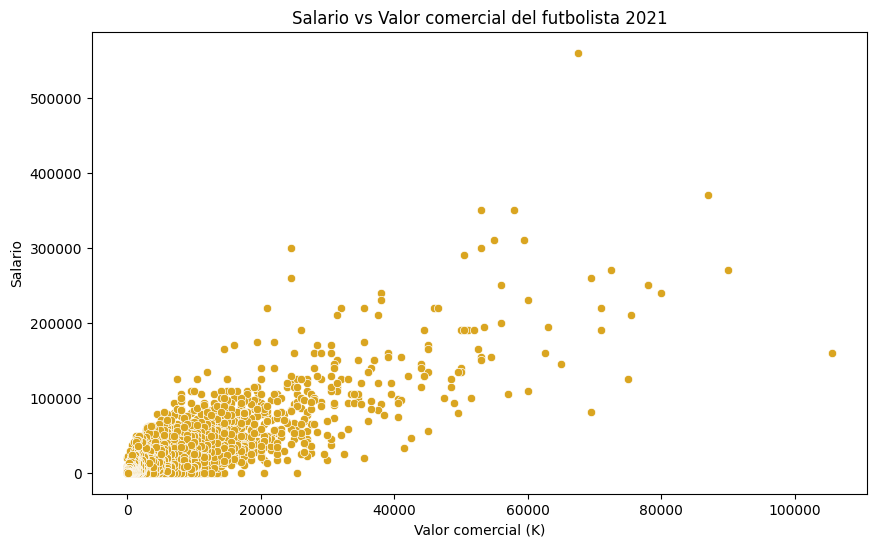

In [28]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Value_(K)', y='Wage', data=df, c='goldenrod');

plt.xlabel("Valor comercial (K)")
plt.ylabel("Salario")
plt.title("Salario vs Valor comercial del futbolista 2021");

> A mayor valor en el mercado, mayor es el salario. Sin embargo, se observan casos atípicos especialmente en jugadores con alto valor comercial pero salarios relativamente bajos, lo cual podría indicar futbolistas jóvenes con gran proyección que aún no han firmado contratos lucrativos.

Cuáles son los jugadores con un alto valor de mercado pero que reciben salarios relativamente bajos?

In [29]:
df.query('`Value_(K)` >= 70e3 and Wage <= 250e3') [['Long_name']]

,Long_name
2,Jan Oblak
5,Robert Lewandowski
6,Kylian Mbappé
8,Mohamed Salah
9,Sadio Mané
10,Virgil van Dijk
20,Paulo Dybala
23,Harry Kane


## Tasa de Esfuerzo de ataque
Indica cuánto se involucra un jugador en las acciones de ataque durante el partido.

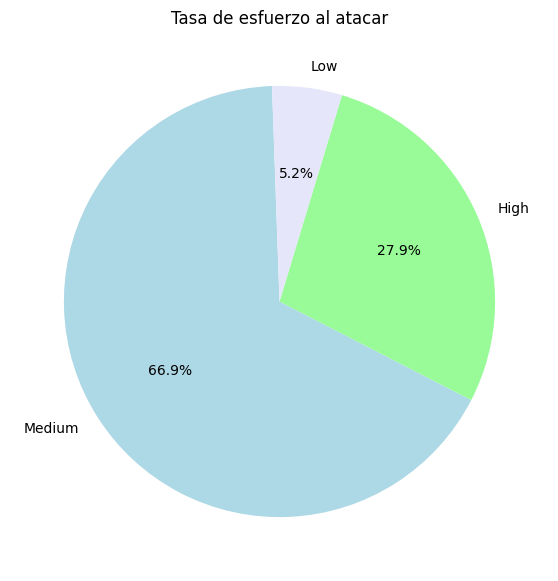

In [30]:
atacking_workrate = df['A/W'].value_counts() # Attacking Workrate

plt.figure(figsize=(7, 7))
plt.pie(atacking_workrate, labels=atacking_workrate.keys(), autopct='%1.1f%%', colors= ["lightblue", "palegreen", "lavender"], startangle=92)
plt.title("Tasa de esfuerzo al atacar");

> La gran mayoría de futbolistas tienen una tasa de esfuerzo ofensivo **media**, mientras que alrededor del **28 %** exhibe un compromiso **alto** en ataque y solo un **5 %** presenta un esfuerzo **bajo**. Esto indica que la mayor parte del equipo contribuye de forma equilibrada en tareas ofensivas, con un grupo notable de jugadores que destacan por su proactividad al atacar.

## Comparacion entre 2 futbolistas

In [31]:
skills=[
    'POT', 'OVA', 'Acceleration', 'Sprint_speed', 'Dribbling', 'Ball_control',
    'Finishing', 'Vision', 'Short_passing', 'Shot_power', 'Stamina', 'Strength',
    'Composure', 'Reactions', 'Agility'
    ]

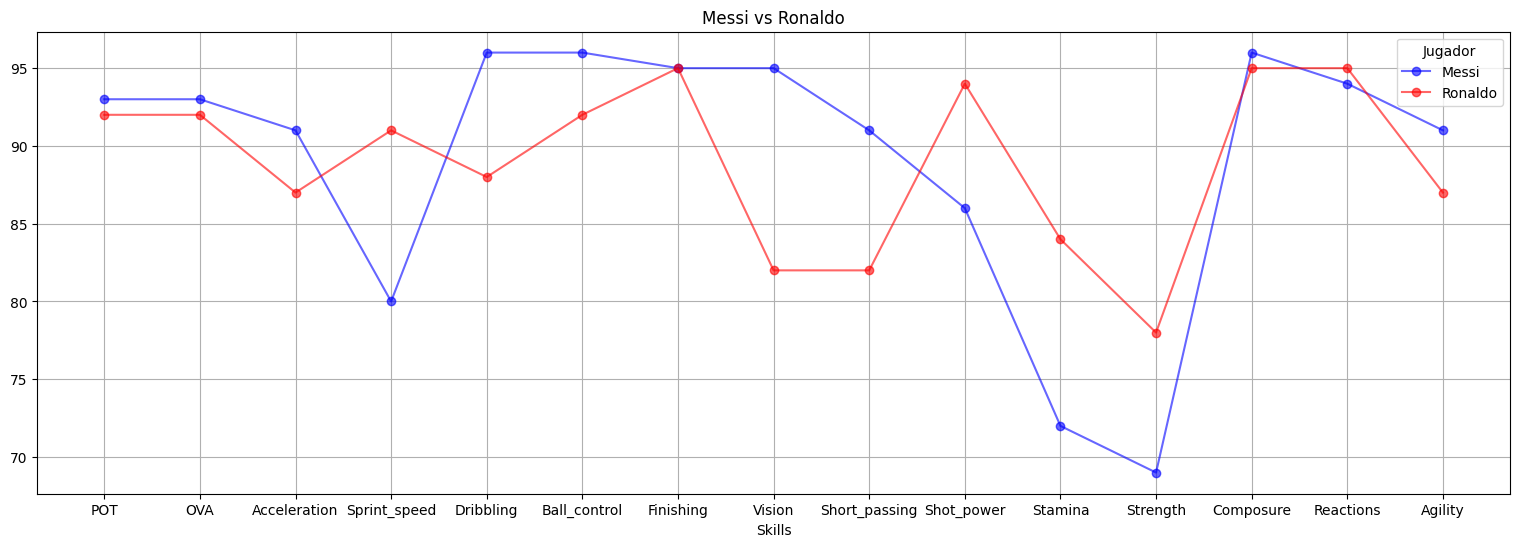

In [32]:
messi = df.loc[df['Long_name'] == 'Lionel Messi', skills].squeeze() # 'squeeze' Para convertirlo en Serie
ronaldo = df.loc[df['Long_name'] == 'C. Ronaldo dos Santos Aveiro', skills].squeeze()

plt.figure(figsize=(19, 6))
plt.plot(skills, messi, label='Messi', c='b', alpha=0.6, marker='o')
plt.plot(skills, ronaldo, label='Ronaldo', color='r', alpha=0.6, marker='o')

plt.xlabel('Skills')
plt.title('Messi vs Ronaldo')
plt.legend(title='Jugador')
plt.grid();

> Messi destaca notablemente en Dribbling, Control del balón, Visión y Pase corto, cualidades que evidencian su estilo de juego técnico. En contraste, Ronaldo sobresale en Velocidad, Potencia de tiro, Fuerza y Reacciones, atributos que reflejan un perfil más físico y explosivo.		<br><br> 
Ambos jugadores muestran un rendimiento muy equilibrado en aspectos clave como la Finalización, Compostura y sus calificaciones generales (POT y OVA), lo que reafirma su estatus como los mejores futbolistas del mundo en el 2021.